# TreeEnsembleRegressor and parallelisation

The operator [TreeEnsembleClassifier](https://github.com/onnx/onnx/blob/master/docs/Operators-ml.md#ai.onnx.ml.TreeEnsembleClassifier) describe any tree model (decision tree, random forest, gradient boosting). The runtime is usually implements in C/C++ and uses parallelisation. The notebook studies the impact of the parallelisation.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Graph

The following dummy graph shows the time ratio between two runtimes depending on the number of observations in a batch (N) and the number of trees in the forest.

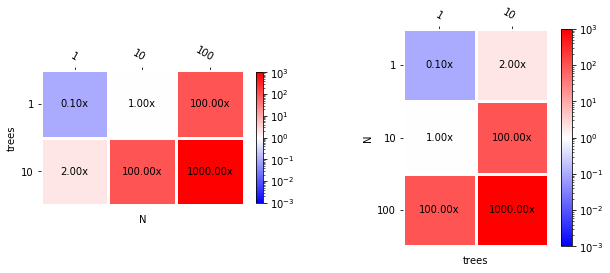

In [3]:
import matplotlib.pyplot as plt
from mlprodict.tools.plotting import plot_benchmark_metrics


def plot_metric(metric, ax=None, xlabel="N", ylabel="trees", middle=1.,
                transpose=False, shrink=1.0, title=None, figsize=None):
    if figsize is not None and ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
        
    ax, cbar = plot_benchmark_metrics(metric, ax=ax, xlabel=xlabel, ylabel=ylabel,
                                      middle=middle, transpose=transpose,
                                      cbar_kw={'shrink': shrink})
    if title is not None:
        ax.set_title(title)
    return ax

    
data = {(1, 1): 0.1, (10, 1): 1, (1, 10): 2,
        (10, 10): 100, (100, 1): 100, (100, 10): 1000}

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_metric(data, ax[0], shrink=0.6)
plot_metric(data, ax[1], transpose=True);

## scikit-learn: T trees vs 1 tree

Let's do first compare a *GradientBoostingClassifier* from *scikit-learn* with 1 tree against multiple trees.

In [4]:
from sklearn.datasets import make_classification
ntest = 10000
X, y = make_classification(n_samples=10000 + ntest, n_features=10, n_informative=5,
                           n_classes=2, random_state=11)
X_train, X_test, y_train, y_test = X[:-ntest], X[-ntest:], y[:-ntest], y[-ntest:]

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm

ModelToTest = GradientBoostingClassifier

N = [1, 10, 100, 1000, 10000]
T = [1, 2, 10, 20, 50]

models = {}
for nt in tqdm(T):
    rf = ModelToTest(n_estimators=nt, max_depth=7).fit(X_train, y_train)
    models[nt] = rf

100%|██████████| 5/5 [00:11<00:00,  3.04s/it]


In [6]:
import numpy
import sklearn
from mlprodict.onnxrt.validate.validate_benchmark import benchmark_fct

def benchmark(X, fct1, fct2, N, repeat=10, number=20):
    
    def ti(r, n):
        if n <= 1:
            return 40 * r
        if n <= 10:
            return 10 * r
        if n <= 100:
            return 4 * r
        if n <= 1000:
            return r
        return r // 2
    
    with sklearn.config_context(assume_finite=True):
        # to warm up the engine
        time_kwargs = {n: dict(repeat=10, number=10) for n in N}
        benchmark_fct(fct1, X, time_kwargs=time_kwargs, skip_long_test=False)
        benchmark_fct(fct2, X, time_kwargs=time_kwargs, skip_long_test=False)
        # real measure
        time_kwargs = {n: dict(repeat=ti(repeat, n), number=number) for n in N}
        res1 = benchmark_fct(fct1, X, time_kwargs=time_kwargs, skip_long_test=False)
        res2 = benchmark_fct(fct2, X, time_kwargs=time_kwargs, skip_long_test=False)
    res = {}
    for r in sorted(res1):
        r1 = res1[r]
        r2 = res2[r]
        ratio = r2['total'] / r1['total']
        res[r] = ratio
    return res


def tree_benchmark(X, fct1, fct2, T, N, repeat=20, number=10):
    bench = {}
    for t in tqdm(T):
        if callable(X):
            x = X(t)
        else:
            x = X
        r = benchmark(x, fct1(t), fct2(t), N, repeat=repeat, number=number)
        for n, v in r.items():
            bench[n, t] = v
    return bench

bench = tree_benchmark(X_test.astype(numpy.float32),
                       lambda t: models[1].predict,
                       lambda t: models[t].predict, T, N)

list(bench.items())[:3]

100%|██████████| 5/5 [00:28<00:00,  6.36s/it]


[((1, 1), 0.6638794546646888),
 ((10, 1), 0.4602971636828223),
 ((100, 1), 0.4356528708232577)]

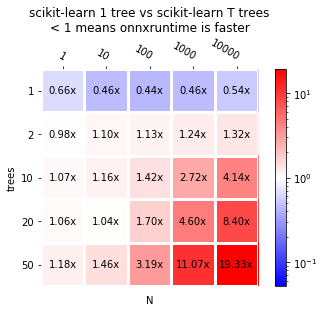

In [7]:
plot_metric(bench, title="scikit-learn 1 tree vs scikit-learn T trees\n"
            "< 1 means onnxruntime is faster");

As expected, all ratio on first line are close to 1 since both models are the same. fourth line, second column (T=20, N=10) means an ensemble with 20 trees is around 5 times slower to compute the predictions of 10 observations in a batch compare to an ensemble with 1 tree.

## scikit-learn against onnxuntime

In [8]:
from skl2onnx import to_onnx
X32 = X_test.astype(numpy.float32)
models_onnx = {t: to_onnx(m, X32[:1]) for t, m in models.items()}

In [9]:
from onnxruntime import InferenceSession
sess_models = {t: InferenceSession(mo.SerializeToString()) 
               for t, mo in models_onnx.items()}

In [10]:
bench_ort = tree_benchmark(
    X_test.astype(numpy.float32),
    lambda t: models[t].predict_proba,
    lambda t: (lambda x, t_=t, se=sess_models: se[t_].run(None, {'X': x})),
    T, N)

100%|██████████| 5/5 [00:59<00:00, 14.61s/it]


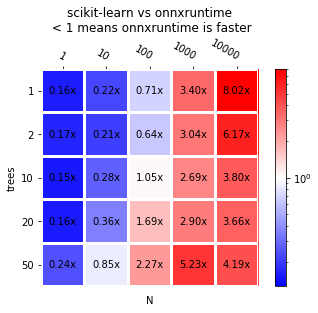

In [11]:
plot_metric(bench_ort, title="scikit-learn vs onnxruntime\n < 1 means onnxruntime is faster");

In [12]:
from onnxruntime import __version__ as ort_version
ort_version

'1.1.997'

We clearly see this version of onnxruntime is fast for small batches, still faster but not that much for big batches.

## ZipMap operator

ZipMap just creates a new container for the same results. The copy may impact the ratio. Let's remove it from the equation.

In [13]:
X32 = X_test.astype(numpy.float32)
models_onnx = {t: to_onnx(m, X32[:1], 
                          options={ModelToTest: {'zipmap': False}})
               for t, m in models.items()}

In [14]:
sess_models = {t: InferenceSession(mo.SerializeToString()) 
               for t, mo in models_onnx.items()}

In [15]:
bench_ort = tree_benchmark(
    X_test.astype(numpy.float32),
    lambda t: models[t].predict_proba,
    lambda t: (lambda x, t_=t, se=sess_models: se[t_].run(None, {'X': x})),
    T, N)

100%|██████████| 5/5 [00:49<00:00, 12.24s/it]


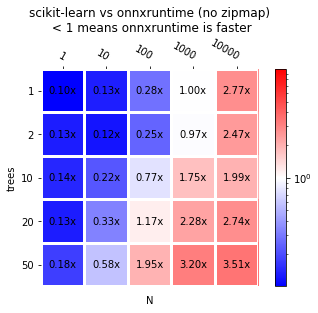

In [16]:
plot_metric(bench_ort, title="scikit-learn vs onnxruntime (no zipmap)\n < 1 "
            "means onnxruntime is faster");

ZipMap removal significantly improves.

## Implementation details for mlprodict runtime

The runtime implemented in [mlprodict]() mostly relies on two files:
* [op_tree_ensemble_common_p_agg_.hpp](https://github.com/sdpython/mlprodict/blob/master/mlprodict/onnxrt/ops_cpu/op_tree_ensemble_common_p_agg_.hpp)
* [op_tree_ensemble_common_p_.hpp](https://github.com/sdpython/mlprodict/blob/master/mlprodict/onnxrt/ops_cpu/op_tree_ensemble_common_p_.hpp)

The runtime builds a tree structure, computes the output of every tree and then agregates them. The implementation distringuishes when the batch size contains only 1 observations or many. It parallelizes on the following conditions:
* if the batch size $N \geqslant N_0$, it then parallelizes per observation, asuming every one is independant,
* if the batch size $N = 1$ and the number of trees $T \geqslant T_0$, it then parallelizes per tree.

## scikit-learn against mlprodict, no parallelisation

In [17]:
from mlprodict.onnxrt import OnnxInference
oinf_models = {t: OnnxInference(mo, runtime="python_compiled") 
               for t, mo in models_onnx.items()}

Let's disable the parallelisation.

In [18]:
for _, oinf in oinf_models.items():
    oinf.sequence_[0].ops_.rt_.omp_tree_ = 10000000
    oinf.sequence_[0].ops_.rt_.omp_N_ = 10000000

In [19]:
bench_mlp = tree_benchmark(
    X_test.astype(numpy.float32),
    lambda t: models[t].predict,
    lambda t: (lambda x, t_=t, oi=oinf_models: oi[t_].run({'X': x})),
    T, N)

100%|██████████| 5/5 [00:31<00:00,  7.74s/it]


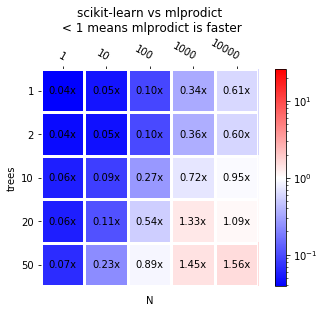

In [20]:
plot_metric(bench_mlp, title="scikit-learn vs mlprodict\n < 1 means mlprodict is faster");

Let's compare *onnxruntime* against *mlprodict*.

In [21]:
bench_mlp_ort = tree_benchmark(
    X_test.astype(numpy.float32),
    lambda t: (lambda x, t_=t, se=sess_models: se[t_].run(None, {'X': x})),
    lambda t: (lambda x, t_=t, oi=oinf_models: oi[t_].run({'X': x})),
    T, N)

100%|██████████| 5/5 [00:45<00:00, 11.73s/it]


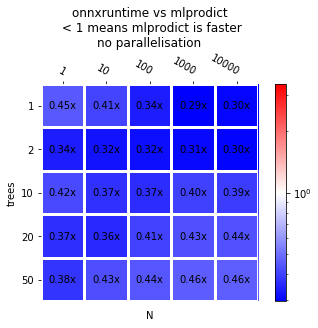

In [22]:
plot_metric(bench_mlp_ort, title="onnxruntime vs mlprodict\n < 1 means mlprodict is faster"
            "\nno parallelisation");

In [23]:
from mlprodict import __version__ as mlp_version
mlp_version

'0.3'

This implementation is clearly faster except for high number of trees or high number of observations. Let's add parallelisation for trees and observations.

In [24]:
for _, oinf in oinf_models.items():
    oinf.sequence_[0].ops_.rt_.omp_tree_ = 2
    oinf.sequence_[0].ops_.rt_.omp_N_ = 2

In [25]:
bench_mlp_para = tree_benchmark(
    X_test.astype(numpy.float32),
    lambda t: models[t].predict,
    lambda t: (lambda x, t_=t, oi=oinf_models: oi[t_].run({'X': x})),
    T, N)

100%|██████████| 5/5 [00:24<00:00,  5.60s/it]


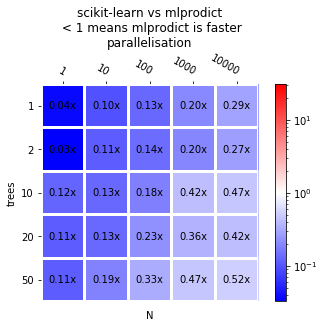

In [26]:
plot_metric(bench_mlp_para, title="scikit-learn vs mlprodict\n < 1 means "
            "mlprodict is faster\nparallelisation");

Parallelisation does improve the computation time when N is big. Let's compare with and without parallelisation.

In [27]:
bench_para = {}
for k, v in bench_mlp.items():
    bench_para[k] = bench_mlp_para[k] / v

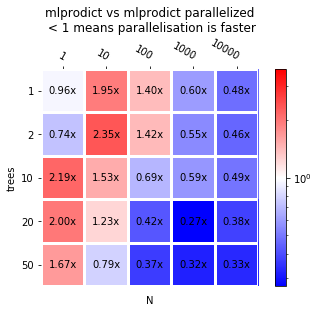

In [28]:
plot_metric(bench_para, title="mlprodict vs mlprodict parallelized\n < 1 "
            "means parallelisation is faster");

Parallelisation per trees does not seem to be efficient. Let's confirm with a proper benchmark as the previous merges results from two benchmarks.

In [29]:
for _, oinf in oinf_models.items():
    oinf.sequence_[0].ops_.rt_.omp_tree_ = 1000000
    oinf.sequence_[0].ops_.rt_.omp_N_ = 1000000

oinf_models_para = {t: OnnxInference(mo, runtime="python_compiled") 
                    for t, mo in models_onnx.items()}
for _, oinf in oinf_models_para.items():
    oinf.sequence_[0].ops_.rt_.omp_tree_ = 2
    oinf.sequence_[0].ops_.rt_.omp_N_ = 2

bench_mlp_para = tree_benchmark(
    X_test.astype(numpy.float32),
    lambda t: (lambda x, t_=t, oi=oinf_models: oi[t_].run({'X': x})),
    lambda t: (lambda x, t_=t, oi=oinf_models_para: oi[t_].run({'X': x})),
    T, N, repeat=20, number=20)

100%|██████████| 5/5 [00:30<00:00,  7.76s/it]


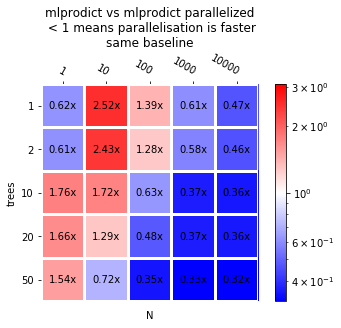

In [30]:
plot_metric(bench_mlp_para, title="mlprodict vs mlprodict parallelized\n < 1 means parallelisation "
            "is faster\nsame baseline");

It should be run on different machines. On the current one, parallelisation per trees (when N=1) does not seem to help. Parallelisation for a small number of observations does not seem to help either. So we need to find some threshold.

## Parallelisation per trees

Let's study the parallelisation per tree. We need to train new models.

In [31]:
N2 = [1, 10]

In [32]:
T2 = [1, 2, 10, 50, 100, 150, 200, 300, 400, 500]

models2 = {}
for nt in tqdm(T2):
    rf = ModelToTest(n_estimators=nt, max_depth=7).fit(X_train, y_train)
    models2[nt] = rf

100%|██████████| 10/10 [02:11<00:00, 24.53s/it]


Conversion to ONNX.

In [33]:
X32 = X_test.astype(numpy.float32)
models2_onnx = {t: to_onnx(m, X32[:1]) for t, m in models2.items()}

oinf_models2 = {t: OnnxInference(mo, runtime="python_compiled") for t, mo in models2_onnx.items()}
for _, oinf in oinf_models2.items():
    oinf.sequence_[0].ops_.rt_.omp_tree_ = 1000000
    oinf.sequence_[0].ops_.rt_.omp_N_ = 1000000

oinf_models2_para = {t: OnnxInference(mo, runtime="python_compiled") for t, mo in models2_onnx.items()}
for _, oinf in oinf_models2_para.items():
    oinf.sequence_[0].ops_.rt_.omp_tree_ = 2
    oinf.sequence_[0].ops_.rt_.omp_N_ = 100

And benchmark.

In [34]:
bench_mlp_tree = tree_benchmark(
    X_test.astype(numpy.float32),
    lambda t: (lambda x, t_=t, oi=oinf_models2: oi[t_].run({'X': x})),
    lambda t: (lambda x, t_=t, oi=oinf_models2_para: oi[t_].run({'X': x})),
    T2, N2, repeat=20, number=20)

100%|██████████| 10/10 [00:22<00:00,  3.97s/it]


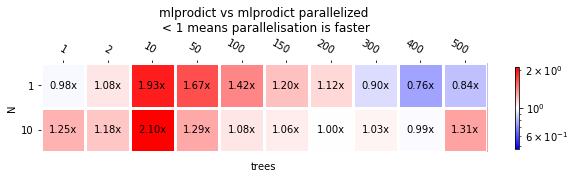

In [35]:
plot_metric(bench_mlp_tree, transpose=True, figsize=(10, 3), shrink=0.5,
            title="mlprodict vs mlprodict parallelized\n < 1 means parallelisation "
            "is faster");

The parallelisation starts to be below 1 after 400 trees. For 10 observations, there is no parallelisation neither by trees nor by observations. Ratios are close to 1. The gain obviously depends on the tree depth. You can try with a different max depth and the number of trees parallelisation becomes interesting depending on the tree depth.

## Multi-Class DecisionTreeClassifier

Same experiment when the number of tree is 1 but then we change the number of classes.

In [36]:
from sklearn.tree import DecisionTreeClassifier
ModelToTest = DecisionTreeClassifier

C = [2, 5, 10, 15, 20, 30, 40, 50]
N = [1, 10, 100, 1000, 10000]
trees = {}
for cl in tqdm(C):
    
    ntest = 10000
    X, y = make_classification(n_samples=10000 + ntest, n_features=12, n_informative=8,
                               n_classes=cl, random_state=11)
    X_train, X_test, y_train, y_test = X[:-ntest], X[-ntest:], y[:-ntest], y[-ntest:]
    
    dt = ModelToTest(max_depth=7).fit(X_train, y_train)
    
    X32 = X_test.astype(numpy.float32)
    monnx = to_onnx(dt, X32[:1])
    oinf = OnnxInference(monnx)
    oinf.sequence_[0].ops_.rt_.omp_N_ = 1000000
    trees[cl] = dict(model=dt, X_test=X_test, X32=X32, monnx=monnx, oinf=oinf)

100%|██████████| 8/8 [00:02<00:00,  2.50it/s]


In [37]:
bench_dt = tree_benchmark(lambda cl: trees[cl]['X32'],
                          lambda cl: trees[cl]['model'].predict_proba,
                          lambda cl: (lambda x, c=cl: trees[c]['oinf'].run({'X': x})),
                          C, N)

100%|██████████| 8/8 [00:16<00:00,  2.28s/it]


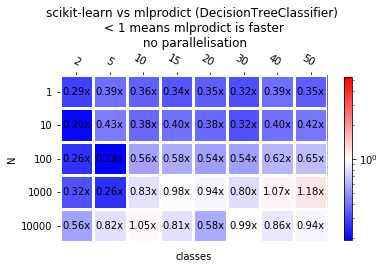

In [38]:
plot_metric(bench_dt, ylabel="classes", transpose=True, shrink=0.75,
            title="scikit-learn vs mlprodict (DecisionTreeClassifier) \n"
            "< 1 means mlprodict is faster\n no parallelisation");

## Multi-class LogisticRegression

In [39]:
from sklearn.linear_model import LogisticRegression
ModelToTest = LogisticRegression

C = [2, 5, 10, 15, 20]
N = [1, 10, 100, 1000, 10000]

models = {}
for cl in tqdm(C):
    
    ntest = 10000
    X, y = make_classification(n_samples=10000 + ntest, n_features=10, n_informative=6,
                               n_classes=cl, random_state=11)
    X_train, X_test, y_train, y_test = X[:-ntest], X[-ntest:], y[:-ntest], y[-ntest:]
    
    model = ModelToTest().fit(X_train, y_train)
    
    X32 = X_test.astype(numpy.float32)
    monnx = to_onnx(model, X32[:1])
    oinf = OnnxInference(monnx)
    models[cl] = dict(model=model, X_test=X_test, X32=X32, monnx=monnx, oinf=oinf)

100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


In [40]:
bench_lr = tree_benchmark(lambda cl: models[cl]['X32'],
                          lambda cl: models[cl]['model'].predict_proba,
                          lambda cl: (lambda x, c=cl: trees[c]['oinf'].run({'X': x})),
                          C, N)

100%|██████████| 5/5 [00:10<00:00,  2.25s/it]


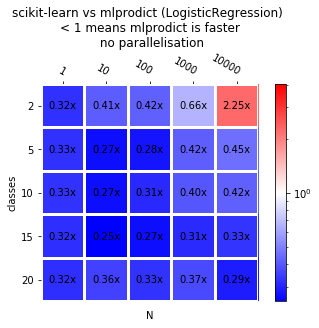

In [41]:
plot_metric(bench_lr, ylabel="classes",
           title="scikit-learn vs mlprodict (LogisticRegression) \n"
           "< 1 means mlprodict is faster\n no parallelisation");

## Decision Tree and number of features

In [42]:
from sklearn.tree import DecisionTreeClassifier
ModelToTest = DecisionTreeClassifier

NF = [2, 10, 20, 40, 50, 70, 100, 200, 500, 1000]
N = [1, 10, 100, 1000, 10000, 50000]
trees_nf = {}
for nf in tqdm(NF):
    
    ntest = 10000
    X, y = make_classification(n_samples=10000 + ntest, n_features=nf, n_informative=nf // 2 + 1,
                               n_redundant=0, n_repeated=0,
                               n_classes=2, random_state=11)
    X_train, X_test, y_train, y_test = X[:-ntest], X[-ntest:], y[:-ntest], y[-ntest:]
    
    dt = ModelToTest(max_depth=7).fit(X_train, y_train)
    
    X32 = X_test.astype(numpy.float32)
    monnx = to_onnx(dt, X32[:1])
    oinf = OnnxInference(monnx)
    oinf.sequence_[0].ops_.rt_.omp_N_ = 1000000
    trees_nf[nf] = dict(model=dt, X_test=X_test, X32=X32, monnx=monnx, oinf=oinf)

100%|██████████| 10/10 [00:24<00:00,  5.60s/it]


In [43]:
bench_dt_nf = tree_benchmark(lambda nf: trees_nf[nf]['X32'],
                             lambda nf: trees_nf[nf]['model'].predict_proba,
                             lambda nf: (lambda x, c=nf: trees_nf[c]['oinf'].run({'X': x})),
                             NF, N)

100%|██████████| 10/10 [00:46<00:00,  6.20s/it]


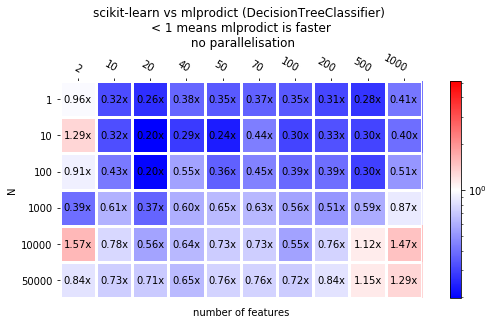

In [44]:
plot_metric(bench_dt_nf, ylabel="number of features", transpose=True, figsize=(10, 4),
            title="scikit-learn vs mlprodict (DecisionTreeClassifier) \n"
            "< 1 means mlprodict is faster\n no parallelisation");